<div style="text-align: right">
    <img src="img/BBWS2023_cropped.png" alt="" width="1200" id="hp"/>
</div>

# Tutorial 1: from BigBrains to BrainSpaces

🇮🇸 7th BigBrain Workshop, Reykjavík, Iceland, October 4 2023.

**Content creators:** Jessica Royer, Raul R. Cruces, Boris Bernhardt. MICA lab

## 🐳 Tutorial Objectives

Estimated duration of tutorial: 70 minutes

### 🌋 Contextualization of BigBrain in a standarized MRI-compatible surface space
1. In this notebook we'll use the BigBrain intensities mapped to an standard cortical surface (fsLR-32k, Glasser et al. 2013, NeuroImage). 
2. Build a microstructural profile covariance matrix derived from the BigBrain intensities
3. Use a dimensionality reduction technique to highlight the major axes of variance in the MPC matrix.
4. Use an openly available MRI 3T dataset to assess the similarity between BigBrain histological stain intensities and a myelin-sensitive MRI acquisition.

### 🏔️ Overview:

1. Download pre-generated BigBrain intensity profiles using BrainStat
2. Plot vertexwise mean intensities on the cortical surface
3. Calculate the MPC matrix on parcellated BigBrain intensity data (MPC-Hist)
4. Apply diffusion map embedding to obtain eigenvectors or gradients of the MPC-Hist matrix
5. Download qT1 MPC from the public repository MICA-MICs (MPC-MRI)
6. Calculate the group-average MPC-MRI
7. Apply diffusion map embedding to obtain eigenvectors or gradients of the MPC-MRI matrix.
8. Calculate the correlation between gradients generated from histological and qT1 MRI data
9. Use a permutation test to assess the statistical significance the correlation 
10. Plot the correlation with ranked values.


### `Requirements`

<p></p>

<details><summary>▶️ click for details</summary>
<p>
   
```bash
git
bash -y conda -forge install
datalad
datalad-installer
datalad-installer git-annex -m datalad/git-annex:release
numpy
nilearn
wordcloud
matplotlib
pandas
scipy
h5py
pip "brainspace brainstat"
```

</p>
</details>

# BigBrain intensities on fsLR32k

<p></p>

<div style="text-align: center">
    <img src="img/bigbrain_mpc.png" alt="" width="800" id="hp"/>
</div>

> Paquola et al. "The BigBrainWarp toolbox for integration of BigBrain 3D histology with multimodal neuroimaging." Elife 10 (2021): e70119. [10.7554/eLife.70119] (https://doi.org/10.7554/eLife.70119) 

> Paquola et al. "Microstructural and functional gradients are increasingly dissociated in transmodal cortices." PLoS biology 17.5 (2019): e3000284. [0.1371/journal.pbio.3000284] (https://doi.org/10.1371/journal.pbio.3000284)


# 1. Download pre-generated BigBrain intensity profiles using `BrainStat` 

In [21]:
import h5py
from brainstat.context.histology import download_histology_profiles

# Download BigBrain histological profiles
# other template provided by BrainStat is: fsaverage
# Data and processed gradients also available in the BigBrainWarp toolbox
download_histology_profiles(data_dir='./', template='fslr32k', overwrite=True)
download_histology_profiles(data_dir='./', template='fsaverage5', overwrite=True)

# Read the file
h5 = h5py.File('./histology_fslr32k.h5','r')
histology_profiles=h5['fs_LR_64k']

# Read the file
h5 = h5py.File('./histology_fsaverage5.h5','r')
histology_profiles_fs5=h5['fsaverage5']

# Print file information
histology_profiles

2023-09-26 14:40:44,973 - brainstat - INFO - Downloading histology_fslr32k.h5 from https://box.bic.mni.mcgill.ca/s/6zKHcg9xXu5inPR/download.
2023-09-26 14:40:47,003 - brainstat - INFO - Downloading histology_fsaverage5.h5 from https://box.bic.mni.mcgill.ca/s/N8zstvuRb4sNcSe/download.


<HDF5 dataset "fs_LR_64k": shape (50, 64984), type "<f8">

In [22]:
from brainstat.datasets import fetch_template_surface

# Load surfaces
inf_left, inf_right = fetch_template_surface("fslr32k", join=False, layer='inflated')
fs5_left, fs5_right = fetch_template_surface("fsaverage5", join=False, layer='inflated')

<details><summary> ▶️ fetch_template_surface surfaces</summary>
<p>


> **template:** Cortical surface template to use. Valid values are ‘fsaverage5’, ‘fsaverage6’, ‘fsaverage’, ‘fslr32k’, ‘civet41k’, ‘civet164k’.
    
</p>
</details>

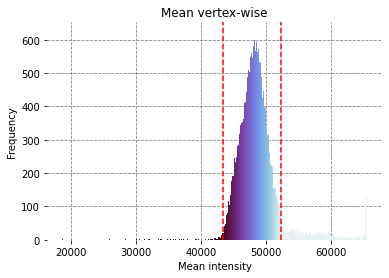

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean
import cmocean.cm as cmo

# Calculate vertex-wise mean intensity profiles
histology_profiles_mean = np.mean(histology_profiles, axis=0)

# Calculate quantile range for plotting
Range=(np.quantile(histology_profiles_mean, 0.005), np.quantile(histology_profiles_mean, 0.925))

# Left subplot - Histogram for feature
n, bins, _ = plt.hist(histology_profiles_mean, bins=1000)
bin_centers = (bins[:-1] + bins[1:]) / 2  # Compute the bin centers
colormap = cm.get_cmap('cmo.dense_r')
colored_bins = colormap(np.interp(bin_centers, [Range[0], Range[1]], [0, 1]))
plt.bar(bin_centers, n, width=np.diff(bins), color=colored_bins)
plt.xlabel('Mean intensity', fontsize=10)  # Increase font size for x-label
plt.ylabel('Frequency', fontsize=10)       # Increase font size for y-label
plt.title('Mean vertex-wise', fontsize=12)   # Increase font size for title

# Add vertical red lines at the values in Range
plt.axvline(Range[0], color='red', linestyle='--', label='Range Start')
plt.axvline(Range[1], color='red', linestyle='--', label='Range End')

# Remove the outer box line
for spine in plt.gca().spines.values():
    spine.set_visible(False)
# Set the grid on the back
plt.gca().set_axisbelow(True)
plt.grid(color='gray', linestyle='dashed')

# 2. Plot vertexwise mean intensities on the cortical surface

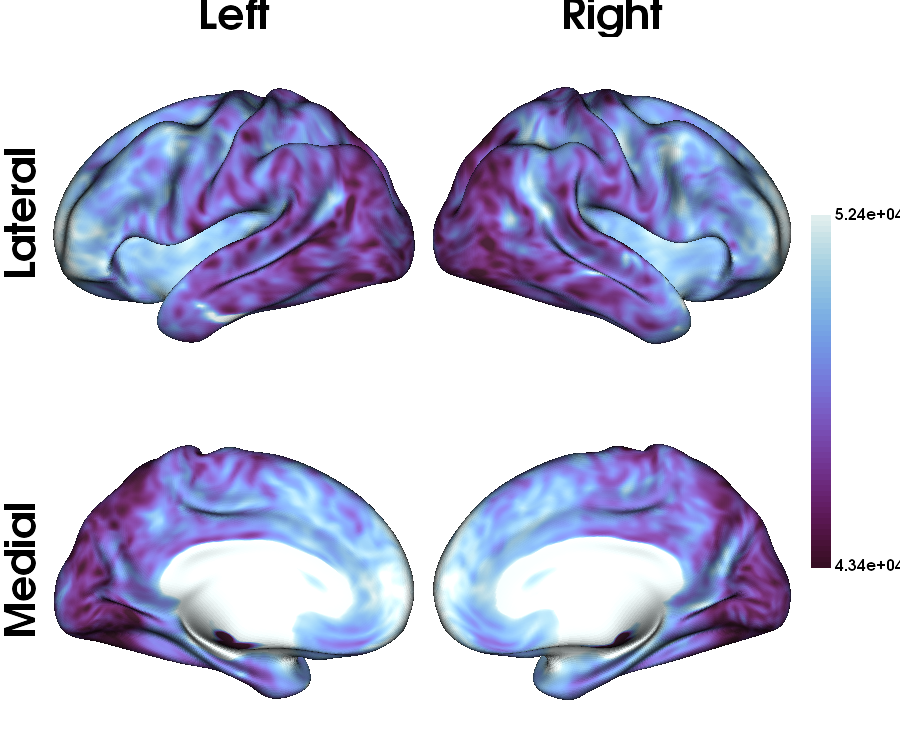

In [24]:
from brainspace.plotting import plot_hemispheres

# Plot the vertexwise mean intensity profile
plot_hemispheres(inf_left, inf_right, 
                 array_name=histology_profiles_mean, 
                 nan_color=(0, 0, 0, 1),
                 zoom=1.3, 
                 size=(900, 750), 
                 embed_nb=True,
                 color_bar='right',
                 layout_style='grid',
                 color_range=Range,
                 cmap='cmo.dense_r',
                 label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']}
                )

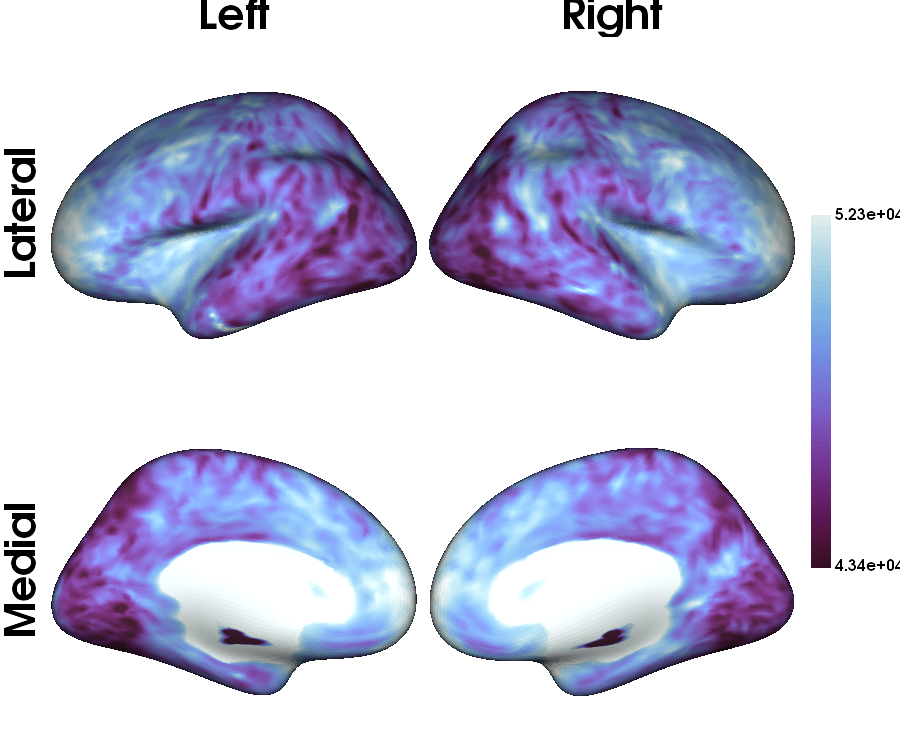

In [25]:
# Calculate vertexwise mean intensity profile
histology_profiles_mean_fs5 = np.mean(histology_profiles_fs5, axis=0)

# Calculate quantile range for plotting
Range=(np.quantile(histology_profiles_mean_fs5, 0.005), np.quantile(histology_profiles_mean_fs5, 0.925))

# Plot the vertex-wise mean intensity profile
plot_hemispheres(fs5_left, fs5_right, 
                 array_name=histology_profiles_mean_fs5, 
                 nan_color=(0, 0, 0, 1),
                 zoom=1.3, 
                 size=(900, 750), 
                 embed_nb=True,
                 color_bar='right',
                 layout_style='grid',
                 color_range=Range,
                 cmap='cmo.dense_r',
                 label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']}
                )

# 3. Calculate the MPC matrix on parcellated BigBrain intensity data (MPC-Hist)

## What is microstructural profile covariance or MPC? 🤔
MPC is a technique that simply computes a partial correlation between all pairs of intensity profiles sampled along the cortical mesh, while controlling for the cortex-wide average profile. This way, positive correlations indicate that two regions show similar shapes in their intensity profiles, above and beyond the overall average profile shape found across the cortex.

<div style="text-align: center">
<img src="https://oup.silverchair-cdn.com/oup/backfile/Content_public/Journal/brain/146/9/10.1093_brain_awad125/1/awad125f1.jpeg?Expires=1697661260&Signature=iom0awZonSDzswt5gRNIdp5wK7KwVa-UGon3eJiJYD3iK9rGExDHDQ~AyhYiJCU-GLkPYePpcTLaEAhbmhPQD0Wqn-6pCUmT8g8xdJdWtaGZisfAq8L31jWndioJWp~R5IpRBMxMfbjSKDiK0JmmRj1HaBGSiSstFnAcdgHygsuI2d7NiEklw2jsE3SsClQWjWMd5jkmuJhT5t9N689INXt9kQeSmyEz9Yfi2WHcODKXUF0d13qO8uiBw9uC1KnvMRwzU3jSMOjw9GaSjhmrYwz9JwLVLpvGCwJ-9vqlvaYqoPgoxFNo~XqM5Xai8dhlK3oXnUpZT4lJCkh-CEan8A__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA" alt="" width="600" id="hp"/>
</div>

> Royer et al. "Cortical microstructural gradients capture memory network reorganization in temporal lobe epilepsy." Brain 146.9 (2023): 3923-3937. https://doi.org/10.1093/brain/awad125

## How it the MPC matrix calculated?
Vertex-wise intensity profiles are cross-correlated using partial correlations controlling for the average cortex-wide intensity profile, and log-transformed. The result constitutes a given participant's MPC matrix representing individual-specific similarity in myelin proxies across the cortex.

In [26]:
from brainstat.datasets import fetch_parcellation

# Fetch an atlas parcellation
atlas = fetch_parcellation(template="fslr32k", atlas="schaefer", n_regions=800)

# Get the mask
mask = atlas != 0

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


2023-09-26 14:41:12,841 - nibabel.global - WARNING - pixdim[1,2,3] should be non-zero; setting 0 dims to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-09-26 14:41:12,842 - nibabel.global - INFO - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


<details><summary> ▶️ fetch_parcellation details</summary>
<p>
    
```python
def fetch_parcellation(
    template: str,
    atlas: str,
    n_regions: int,
    join: bool = True,
    seven_networks: bool = True,
    data_dir: Optional[Union[str, Path]] = None,
) -> Union[np.ndarray, Tuple[np.ndarray, np.ndarray]]:
    """Loads the surface parcellation of a given atlas.

    Parameters
    ----------
    template : str,
        The surface template. Valid values are "fsaverage", "fsaverage5",
        "fsaverage6", "fslr32k", "civet41k", "civet164k", by default "fsaverage5".
    atlas : str
        Name of the atlas. Valid names are "cammoun", "glasser", "schaefer", "yeo".
    n_regions : int
        Number of regions of the requested atlas. Valid values for the cammoun
        atlas are 33, 60, 125, 250, 500. Valid values for the glasser atlas are
        360. Valid values for the "schaefer" atlas are 100, 200, 300, 400, 500,
        600, 800, 1000. Valid values for "yeo" are 7 and 17.
    join : bool, optional
        If true, returns parcellation as a single array, if false, returns an
        array per hemisphere, by default True.
    seven_networks : bool, optional
        If true, uses the 7 networks parcellation. Only used for the Schaefer
        atlas, by default True.
    data_dir : str, pathlib.Path, optional
        Directory to save the data, defaults to $HOME_DIR/brainstat_data/parcellation_data.

    Returns
    -------
    np.ndarray or tuple of np.npdarray
        Surface parcellation. If a tuple, then the first element is the left hemisphere.
    """
```
    
</p>
</details>

Text(0.5, 15.0, 'ROI')

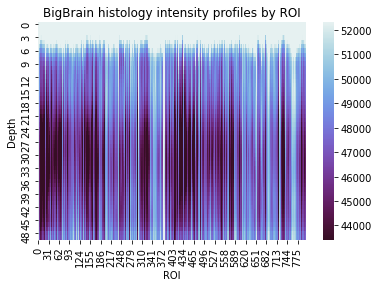

In [27]:
from brainspace.utils.parcellation import reduce_by_labels
import seaborn as sns

# Obtained the ROI based intensity profiles of Big Brain
histology_profiles_roi = reduce_by_labels(histology_profiles, atlas)

# PLot them 
ax = sns.heatmap(histology_profiles_roi, vmin=Range[0], vmax=Range[1], cmap='cmo.dense_r', square=False)
plt.title("BigBrain histology intensity profiles by ROI")
ax.set_ylabel("Depth")
ax.set_xlabel("ROI")

/Users/Jess/miniconda3/envs/python37/lib/python3.7/site-packages/brainstat/context/histology.py:105: RuntimeWarning: divide by zero encountered in true_divide
  mpc = 0.5 * np.log((1 + p_corr) / (1 - p_corr))
/Users/Jess/miniconda3/envs/python37/lib/python3.7/site-packages/brainstat/context/histology.py:105: RuntimeWarning: invalid value encountered in log
  mpc = 0.5 * np.log((1 + p_corr) / (1 - p_corr))


Text(0.5, 15.0, 'ROI')

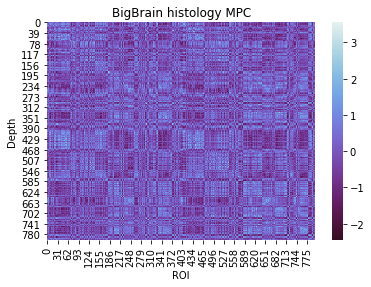

In [28]:
from brainstat.context.histology import compute_mpc

# Compute MPC
MPC_bb = compute_mpc(histology_profiles, labels=atlas)

# Plot the mean MPC matrix
ax = sns.heatmap(MPC_bb, cmap='cmo.dense_r', square=False)
plt.title("BigBrain histology MPC")
ax.set_ylabel("Depth")
ax.set_xlabel("ROI")

<details><summary> ▶️ compute_mpc details</summary>
<p>

```python
def compute_mpc(profile: np.ndarray, labels: np.ndarray) -> np.ndarray:
    """Computes MPC for given labels on a surface template.

    Parameters
    ----------
    profile : numpy.ndarray
        Histological profiles of size surface-by-vertex.
    labels : numpy.ndarray
        Labels of regions of interest. Use 0 to denote regions that will not be included.

    Returns
    -------
    numpy.ndarray
        Microstructural profile covariance.
    """

    roi_profile = reduce_by_labels(profile, labels)
    if np.any(labels == 0):
        # Remove 0's in the labels.
        roi_profile = roi_profile[:, 1:]

    p_corr = partial_correlation(roi_profile, np.mean(profile, axis=1))

    mpc = 0.5 * np.log((1 + p_corr) / (1 - p_corr))
    mpc[p_corr > 0.99999] = 0  # Deals with floating point issues where p_corr==1
    mpc[mpc == np.inf] = 0
    mpc[mpc == np.nan] = 0

    return mpc
```

</p>
</details>

# 4. Apply diffusion map embedding to obtain eigenvectors or gradients of the MPC-Hist matrix

## What are diffusion maps?

Diffusion map embedding is a non-linear algorithm useful in the context of data parametrization and dimensionality reduction. This method helps to simplify and understand complex data: It takes a set of data points and turns them into a map where distances between points represent how similar they are. This map is created by looking at how data spreads out over time, kind of like how heat spreads. 

It is different from other methods because it can handle noisy data and is not limited to straight lines. It helps reveal the underlying structure of the data. They can be applied to problem were linear methods like PCA fail (e.g., swiss roll and complex data). 

<div style="text-align: center">
<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*bLs7TueTiMfznfCaIEvo8A.png" alt="" width="400" id="hp"/>
</div>

> Coifman & Lafon. Diffusion maps. Applied and computational harmonic analysis. 2006 Jul 1;21(1):5-30. https://doi.org/10.1016/j.acha.2006.04.006

## Sounds awesome, how can I apply diffusion maps?

1. Prepare your input matrix (e.g., functional connectivity)
2. We use a kernel function to build the affinity matrix (here, capturing the connectivity of each seed region)
3. This matrix is decomposed using diffusion map embedding into a set of principal eigenvectors describing axes of largest variance
4. The scores of each seed onto the first two axes are shown in the scatter plot, with colors denoting position in this 2D space
5. These colors may be projected back to the cortical surface and the scores can be used to sort the input connectome

<div style="text-align: center">
<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs42003-020-0794-7/MediaObjects/42003_2020_794_Fig1_HTML.png?as=webp" alt="" width="1000" id="hp"/>
</div>

## `BrainSpace`

If you think these steps seem complicated, don't worry 💙 We have a toolbox ready to answer all of your gradient needs. It's called BrainSpace and is available in both MATLAB and Python!!! 🤖 

> Vos de Wael, Benkarim, et al. BrainSpace: a toolbox for the analysis of macroscale gradients in neuroimaging and connectomics datasets. Commun Biol 3, 103 (2020). https://doi.org/10.1038/s42003-020-0794-7 

## How else can we apply diffusion maps to study brain organization?

<p>

<div style="text-align: center">
<img src="https://ars.els-cdn.com/content/image/1-s2.0-S1053811922001161-gr1_lrg.jpg" alt="" width="500" id="hp"/>
</div>

> Bernhardt, Smallwood, Keilholz, Margulies. Gradients in brain organization. NeuroImage. 2022 May 1;251:118987. https://doi.org/10.1016/j.neuroimage.2022.118987

In [29]:
from brainspace.gradient import GradientMaps

# Define the number of gradiants to calculate
Ngrad=10

# kernel = None, 'pearson', 'spearman', 'normalized_angle'
gradient_bb = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel='normalized_angle')
gradient_bb.fit(MPC_bb, sparsity=0.9)

GradientMaps(kernel='normalized_angle')

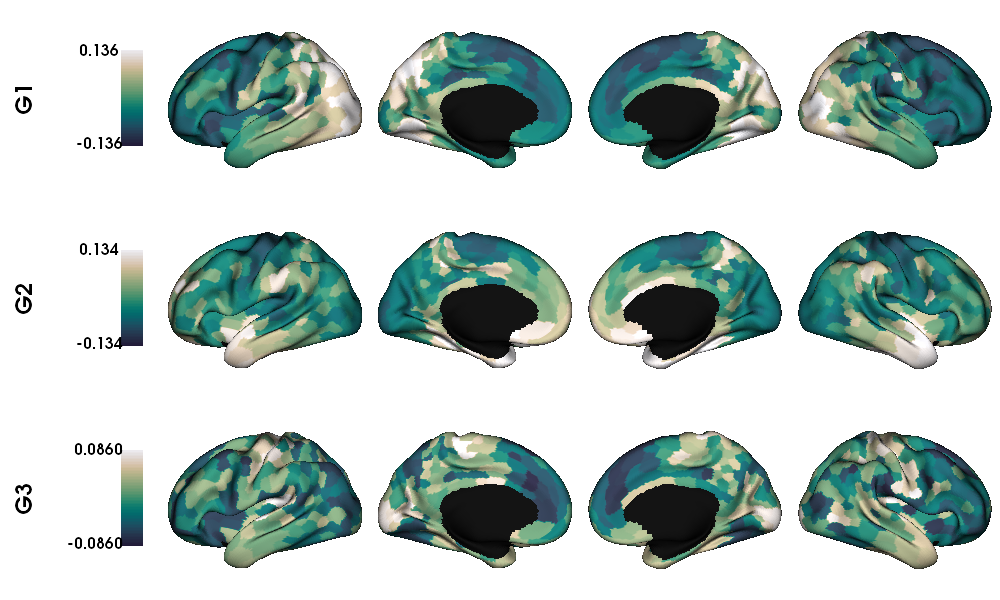

In [30]:
from brainspace.utils.parcellation import map_to_labels

# Map gradients to original parcels
Nplot=3
vertexwise_gradient = [None] * Nplot
for i, g in enumerate(gradient_bb.gradients_.T[0:Nplot,:]):
    vertexwise_gradient[i] = map_to_labels(g, atlas, fill=np.nan, mask=mask != 0)

ylab=['G'+str(x) for x in list(range(1,Nplot+1))]
plot_hemispheres(inf_left, inf_right, 
                 array_name=vertexwise_gradient, 
                 size=(1000, 600), 
                 cmap='cmo.rain_r',
                  embed_nb=True,  
                 label_text={'left':ylab}, 
                 color_bar='left',
                 zoom=1.25, 
                 nan_color=(0, 0, 0, 1), 
                 color_range='sym' )

# 5. Download qT1 MPC from the public repository MICA-MICs (MPC-MRI)
This data is part of the derivatives that were generated using micapipe from the Microstructure-Informed Connectomics (MICA-MICs) open dataset available at the CONP portal (https://n2t.net/ark:/70798/d72xnk2wd397j190qv).


## Why quantitative T1 mapping (qT1)?
Measurement of longitudinal relaxation time (T1) on MRI, referred to as quantitative T1 mapping (qT1), may be sensitive to grey matter myelin content.

<div style="text-align: center">
<img src="https://ars.els-cdn.com/content/image/1-s2.0-S1053811914001359-gr1_lrg.jpg" alt="" width="800" id="hp"/>
</div>

> Stüber et al. "Myelin and iron concentration in the human brain: a quantitative study of MRI contrast." Neuroimage 93 (2014): 95-106. https://doi.org/10.1016/j.neuroimage.2014.02.026


## How can we generate MRI-based MPC matrices?

1. Calculate your own MPC matrices processing your quantitative MRI with `micapipe` MPC processing ([click here for mode details](https://micapipe.readthedocs.io/en/latest/pages/02.microstructproc/index.html)). 

<div style="text-align: center">
<a href="https://micapipe.readthedocs.io/en/latest/index.html"><img src="https://raw.githubusercontent.com/MICA-MNI/micapipe/master/docs/figures/micapipe.png" alt="" width="200" id="hp"/>
</div>


2. Use an online already processed dataset like **MICA-MICs**: A dataset for Microstructure-Informed Connectomics. This dataset is hosted on The Canadian Open Neuroscience Platform:  https://portal.conp.ca/dataset?id=projects/mica-mics

<div style="text-align: center">
<a href="https://portal.conp.ca/dataset?id=projects/mica-mics"><img src="https://portal.conp.ca/dataset_logo?id=projects/mica-mics" alt="" width="200" id="hp"/>
</div>
    
> Royer et al. "An open MRI dataset for multiscale neuroscience." Scientific Data 9.1 (2022): 569. https://doi.org/10.1093/brain/awad125

## Download the data using `datalad`
> Requires `git` and `git-annex`. For more information installing datalad [click here](https://handbook.datalad.org/en/latest/intro/installation.html#install).

In [32]:
%%bash

# Initialize the CONP dataset
datalad install https://github.com/CONP-PCNO/conp-dataset.git

# Install the MICA-MICs dataset
cd conp-dataset
datalad install projects/mica-mics

# See if it worked
tree -d projects/mica-mics/MICs_release/derivatives/micapipe/sub-HC001/*

install(ok): /Users/Jess/Documents/2023_BigBrain_workshop_BigBrains-BrainSpaces/code/conp-dataset (dataset)
install(ok): /Users/Jess/Documents/2023_BigBrain_workshop_BigBrains-BrainSpaces/code/conp-dataset/projects/mica-mics (dataset) [Installed subdataset in order to get /Users/Jess/Documents/2023_BigBrain_workshop_BigBrains-BrainSpaces/code/conp-dataset/projects/mica-mics]


[INFO] Attempting a clone into /Users/Jess/Documents/2023_BigBrain_workshop_BigBrains-BrainSpaces/code/conp-dataset 
[INFO] Attempting to clone from https://github.com/CONP-PCNO/conp-dataset.git to /Users/Jess/Documents/2023_BigBrain_workshop_BigBrains-BrainSpaces/code/conp-dataset 
[INFO] Start enumerating objects 
[INFO] Start counting objects 
[INFO] Start compressing objects 
[INFO] Start receiving objects 
[INFO] Start resolving deltas 
[INFO] Completed clone attempts for Dataset(/Users/Jess/Documents/2023_BigBrain_workshop_BigBrains-BrainSpaces/code/conp-dataset) 
[INFO] Remote origin not usable by git-annex; setting annex-ignore 
[INFO] https://github.com/CONP-PCNO/conp-dataset.git/config download failed: Not Found 
[INFO] Attempting a clone into /Users/Jess/Documents/2023_BigBrain_workshop_BigBrains-BrainSpaces/code/conp-dataset/projects/mica-mics 
[INFO] Attempting to clone from https://github.com/conpdatasets/mica-mics to /Users/Jess/Documents/2023_BigBrain_workshop_BigBrains

CalledProcessError: Command 'b'\n# Initialize the CONP dataset\ndatalad install https://github.com/CONP-PCNO/conp-dataset.git\n\n# Install the MICA-MICs dataset\ncd conp-dataset\ndatalad install projects/mica-mics\n\n# See if it worked\ntree -d projects/mica-mics/MICs_release/derivatives/micapipe/sub-HC001/*\n'' returned non-zero exit status 127.

In [33]:
%%bash 

# Get only the MPC matrices of Schaefer-800 parcellation
cd conp-dataset
atlas=schaefer800

datalad get projects/mica-mics/MICs_release/derivatives/micapipe/sub-*/ses-*/anat/micro_profiles/*_space-fsnative_atlas-${atlas}_desc-mpc.txt

# Get the participants demographics
datalad get projects/mica-mics/MICs_release/rawdata/participants.tsv


get(ok): projects/mica-mics/MICs_release/derivatives/micapipe/sub-HC017/ses-01/anat/micro_profiles/sub-HC017_ses-01_space-fsnative_atlas-schaefer800_desc-mpc.txt (file) [from web...]
get(ok): projects/mica-mics/MICs_release/derivatives/micapipe/sub-HC002/ses-01/anat/micro_profiles/sub-HC002_ses-01_space-fsnative_atlas-schaefer800_desc-mpc.txt (file) [from web...]
get(ok): projects/mica-mics/MICs_release/derivatives/micapipe/sub-HC010/ses-01/anat/micro_profiles/sub-HC010_ses-01_space-fsnative_atlas-schaefer800_desc-mpc.txt (file) [from web...]
get(ok): projects/mica-mics/MICs_release/derivatives/micapipe/sub-HC018/ses-01/anat/micro_profiles/sub-HC018_ses-01_space-fsnative_atlas-schaefer800_desc-mpc.txt (file) [from web...]
get(ok): projects/mica-mics/MICs_release/derivatives/micapipe/sub-HC026/ses-01/anat/micro_profiles/sub-HC026_ses-01_space-fsnative_atlas-schaefer800_desc-mpc.txt (file) [from web...]
get(ok): projects/mica-mics/MICs_release/derivatives/micapipe/sub-HC032/ses-01/anat/m

# 6. Calculate the group-average MPC-MRI

/Users/Jess/miniconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


(800, 800, 50)


(800, 800)

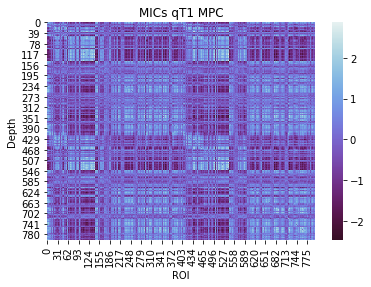

In [34]:
import glob

# Funtion to load and prepare the MPC matrices
def load_mpc(path):
    # Load the cortical connectome
    mtx_mpc = np.loadtxt(path, dtype=np.float, delimiter=' ')

    # Fill the lower triangle of the matrix
    MPC = np.triu(mtx_mpc,1)+mtx_mpc.T

    # Renove the medial wall
    MPC = np.delete(np.delete(MPC, 0, axis=0), 0, axis=1)
    MPC = np.delete(np.delete(MPC, 400, axis=0), 400, axis=1)
    
    # replace values close to 0
    MPC[MPC==0] = np.finfo(float).eps
    return(MPC)

# Load all the files
parc = "schaefer800"
MPC_files=sorted(glob.glob(f"conp-dataset/projects/mica-mics/MICs_release/derivatives/micapipe/sub-*/ses-*/anat/micro_profiles/*_space-fsnative_atlas-{parc}_desc-mpc.txt"))

# Get the dimensions of the MPC matrix
Ndim=load_mpc(MPC_files[0]).shape[0]

# Load all MPC matrices as array
MPC_mics=np.empty([Ndim, Ndim, len(MPC_files)], dtype=float)
for i, f in enumerate(MPC_files):
    #print(f)
    MPC_mics[:,:,i] = load_mpc(f)

# Print the shape of all the loaded MPCs
print(MPC_mics.shape)

# Caculate the group mean MPC
MPC_mics_mean = np.mean(MPC_mics, axis=2)

# Plot the mean MPC matrix
ax = sns.heatmap(MPC_mics_mean, cmap='cmo.dense_r', square=False)
plt.title("MICs qT1 MPC")
ax.set_ylabel("Depth")
ax.set_xlabel("ROI")
MPC_mics_mean.shape

# 8. Apply diffusion map embedding to obtain eigenvectors or gradients of the MPC-MRI matrix.

In [35]:
# Define the number of gradiants to calculate
Ngrad=10

# Calculate the gradients
gradient_mics = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel='normalized_angle')
gradient_mics.fit(MPC_mics_mean, sparsity=0.8)

GradientMaps(kernel='normalized_angle')

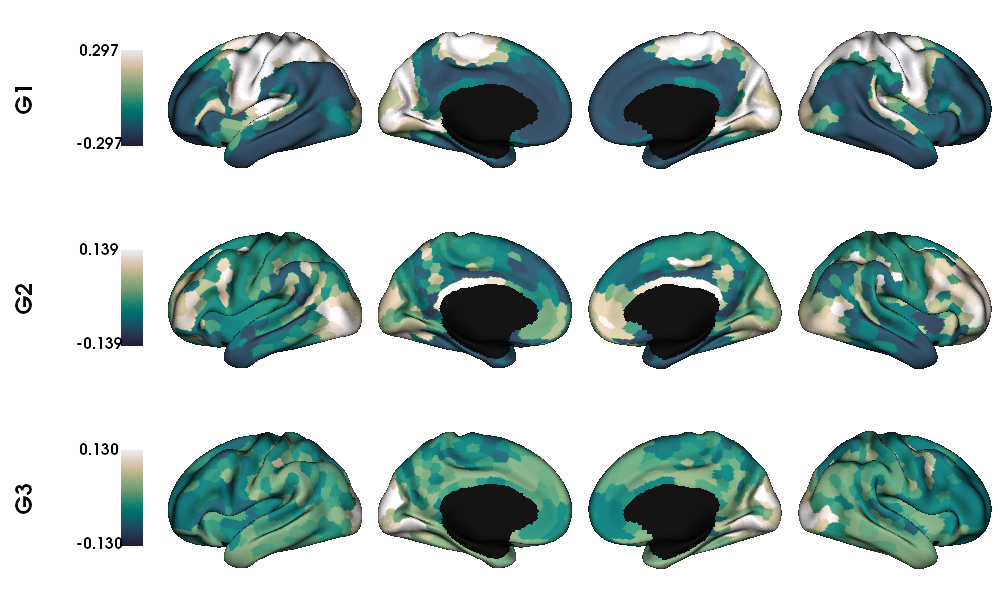

In [36]:
# Map gradients to original parcels
Nplot=3
vertexwise_gradient = [None] * Nplot
for i, g in enumerate(gradient_mics.gradients_.T[0:Nplot,:]):
    vertexwise_gradient[i] = map_to_labels(g, atlas, fill=np.nan, mask=mask != 0)

ylab=['G'+str(x) for x in list(range(1,Nplot+1))]
plot_hemispheres(inf_left, inf_right, 
                 array_name=vertexwise_gradient, 
                 size=(1000, 600), 
                 cmap='cmo.rain_r',
                  embed_nb=True,  
                 label_text={'left':ylab}, 
                 color_bar='left',
                 zoom=1.25, 
                 nan_color=(0, 0, 0, 1), 
                 color_range='sym' )

# 8. Calculate the correlation between gradients generated from histological and qT1 MRI data

In [37]:
# Compute the correlation matrix
corr_bb_mics = np.corrcoef(gradient_mics.gradients_, gradient_bb.gradients_, rowvar=False)
corr_bb_mics.shape

(20, 20)

Text(0.5, 15.0, 'Gradients MPC-Hist')

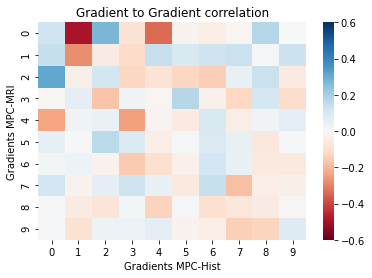

In [38]:
# Plot the correlation matrix
ax = sns.heatmap(corr_bb_mics[:10,10:], cmap='RdBu', square=False, vmin=-0.6, vmax=0.6)
plt.title("Gradient to Gradient correlation")
ax.set_ylabel("Gradients MPC-MRI")
ax.set_xlabel("Gradients MPC-Hist")

#### We see the strongest correlation between MPC-MRI G1 and MPC-Hist G2. Let's look into this a bit deeper 👀

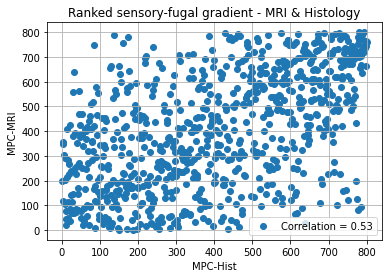

In [39]:
from scipy.stats import spearmanr
from scipy.stats import rankdata

# Store gradients we want to compre in separate variables
g2_his = gradient_bb.gradients_[:,1]*-1
g1_mri = gradient_mics.gradients_[:,0]

# Remove NaN values
valid_indices = ~np.isnan(g2_his) & ~np.isnan(g1_mri)
g2_his = rankdata(g2_his[valid_indices])
g1_mri = rankdata(g1_mri[valid_indices])
#g1_his = g1_his[valid_indices]
#g1_mri = g1_mri[valid_indices]

# Calculate the Spearman rank correlation coefficient
correlation_coefficient, _ = spearmanr(g2_his, g1_mri)

# Create a scatter plot
plt.scatter(g2_his, g1_mri, label=f'Correlation = {correlation_coefficient:.2f}')
plt.xlabel('MPC-Hist')
plt.ylabel('MPC-MRI')
plt.title('Ranked sensory-fugal gradient - MRI & Histology')
plt.legend()
plt.grid(True)

### Plot ranked MPC-Hist G2 on the cortical surface

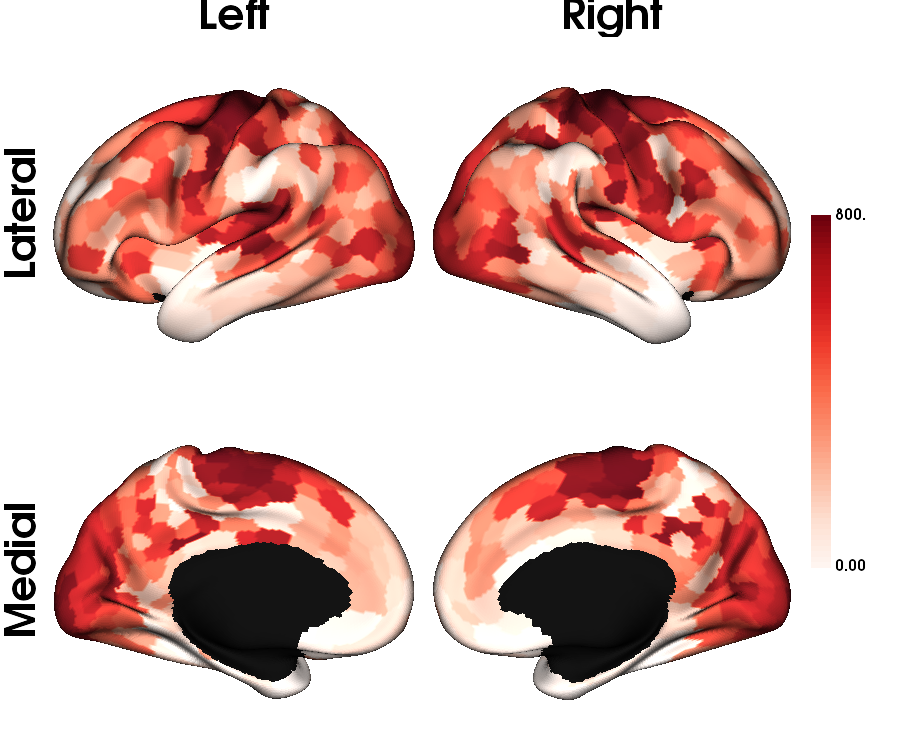

In [40]:
# Map the ROI to the surface vertices for plotting
g2_his_vertex = map_to_labels(g2_his, atlas, fill=np.nan, mask=mask != 0)

# Plot the vertex-wise mean intensity profile
plot_hemispheres(inf_left, inf_right, 
                 array_name=g2_his_vertex, 
                 nan_color=(0, 0, 0, 1),
                 zoom=1.3, 
                 size=(900, 750), 
                 embed_nb=True,
                 color_bar='right',
                 layout_style='grid',
                 color_range=(0, Ndim),
                 cmap='Reds',
                 label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']}
                )

### Compute rank differences between ROIs in MPC-MRI and MPC-Hist sensory-fugal gradients

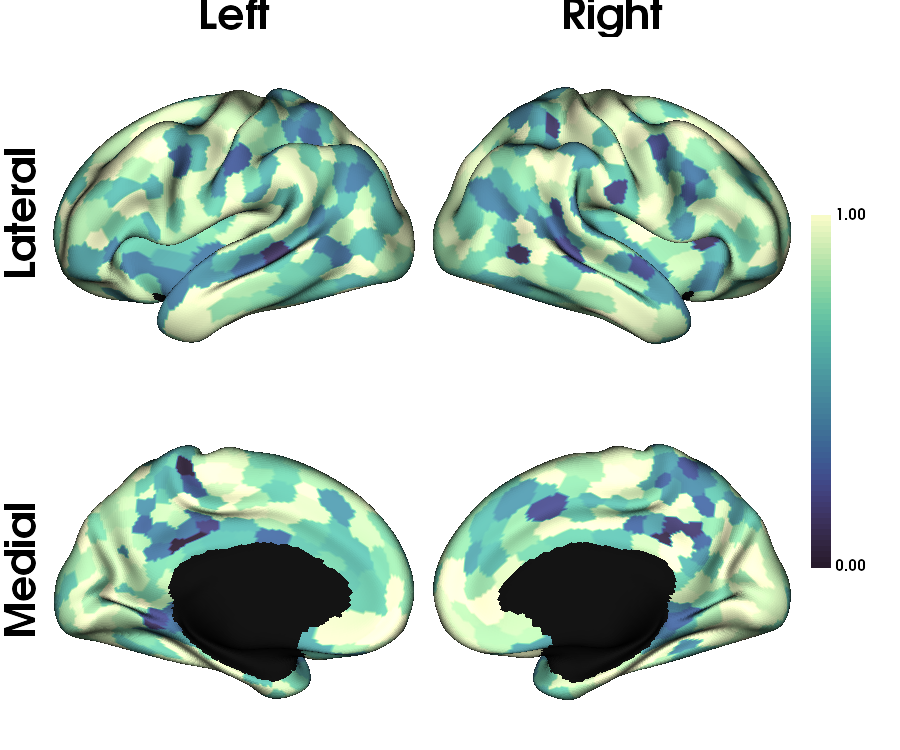

In [41]:
# Calculate the ROI with highest similituded between G2-BigBrain and G1-MRI
g1g2 = (np.abs(g1_mri-g2_his) - np.max(np.abs(g1_mri-g2_his)) )*-1

# Normalize the values between 0 and 1
g1g2_norm = (g1g2-np.min(g1g2))/(np.max(g1g2)-np.min(g1g2))

g1g2_vertex = map_to_labels(g1g2_norm, atlas, fill=np.nan, mask=mask != 0)

# Plot the vertex-wise mean intensity profile
plot_hemispheres(inf_left, inf_right, 
                 array_name=g1g2_vertex, 
                 nan_color=(0, 0, 0, 1),
                 zoom=1.3, 
                 size=(900, 750), 
                 embed_nb=True,
                 color_bar='right',
                 layout_style='grid',
                 cmap='cmo.deep_r',
                 label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']}
                )

# 9. Use a permutation test to assess the statistical significance the correlation 

## Why do we use a permutation test?

Given the spatial autocorrelation present in many modalities, applying linear regression or similar methods may provide biased test statistics. To circumvent this issue, we recommend comparing the observed test statistic to those of a set of distributions with similar spatial autocorrelation. 
 
Here we will use spin permutations. In cases where the input data lies on a surface and most of the sphere is used or if data can be mapped to a sphere, we recommend to use spin permutation. Otherwise, we recommend to use alternative methods such as Moran Spectral Randomization, for instance when analyses are confined to a single subregions of the cortical sheet. When performing a statistical test with multiple gradients as either predictor or response variable, we recommend randomizing the non-gradient variable as these randomizations need not maintain statistical independence across different eigenvectors.

<div style="text-align: center">
<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs42003-020-0794-7/MediaObjects/42003_2020_794_Fig10_HTML.png?as=webp" alt="" width="800" id="hp"/>
</div>


In [45]:
from brainspace.null_models import SpinPermutations
from brainspace.datasets import load_conte69

sphere_lh, sphere_rh = load_conte69(as_sphere=True)

# Let's create some rotations
n_rand = 1000

# Initialize the spin permutation object
sp = SpinPermutations(n_rep=n_rand)
sp.fit(sphere_lh, points_rh=sphere_rh)

SpinPermutations(n_rep=1000)

In [48]:
# Number of vertices
Nv = inf_left.points.shape[0]

# Map the ROI to the surface vertices
g1_mri_vertex = map_to_labels(g1_mri, atlas, fill=np.nan, mask=mask != 0)

# Left and right G1-MRI data
g1_mri_lh = g1_mri_vertex[0:Nv]
g1_mri_rh = g1_mri_vertex[Nv:]

# Rotated G1 from MRI
g1_mri_rotated = np.hstack(sp.randomize(g1_mri_lh, g1_mri_rh))

# Left and right G1-MRI data
g2_his_lh = g2_his_vertex[0:Nv]
g2_his_rh = g2_his_vertex[Nv:]

# Rotated G2 from BigBrain
g2_his_rotated = np.hstack(sp.randomize(g2_his_lh, g2_his_rh))

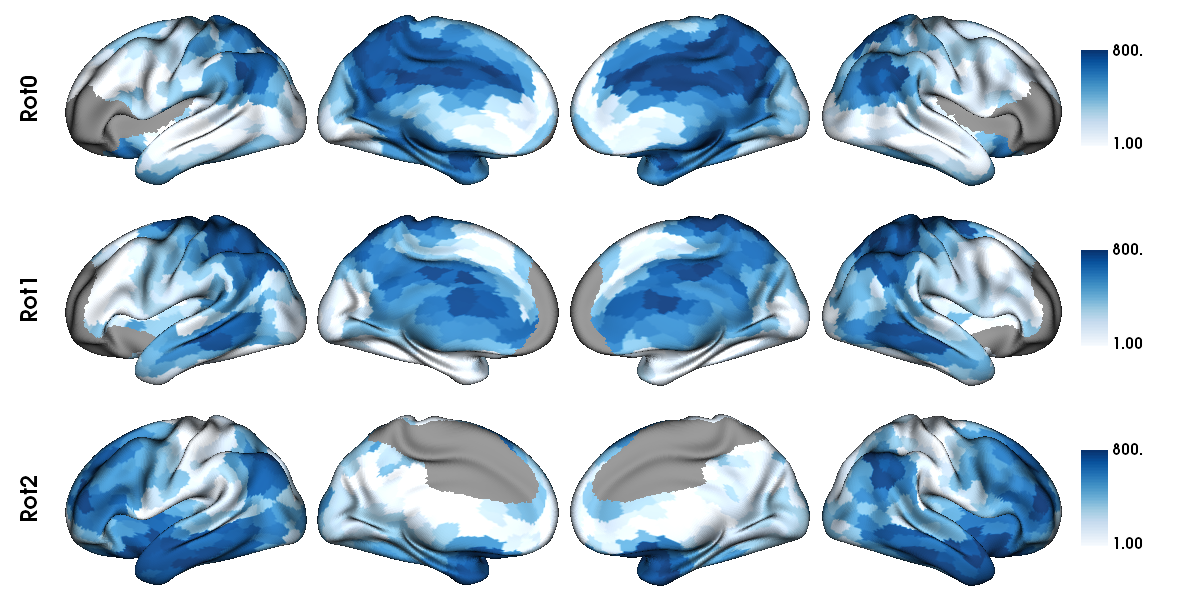

In [49]:
# Plot some rotations
plot_hemispheres(inf_left, inf_right, 
                 array_name=g1_mri_rotated[:3], 
                 size=(1200, 600),
                 cmap='Blues',
                 embed_nb=True,
                 nan_color=(0.5, 0.5, 0.5, 1), 
                 color_bar=True,
                 zoom=1.55, 
                 label_text=['Rot0', 'Rot1', 'Rot2'])

As you can see, the medial wall is also rotated along the mesh (gray region in each surface illustration) - we will need to exclude this region when computing the correlations in each iteration.

Now we simply compute the correlations between the first gradient and the original data, as well as all rotated data.

G1_mri:
 Obs : 0.00000e+00
 Spin: 0.00000e+00



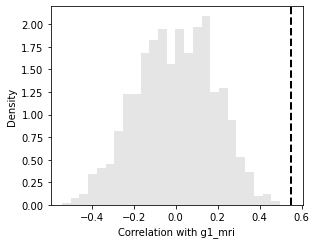

In [51]:
# Create a subplot
fig, axs = plt.subplots(1, 1, figsize=(4.5, 3.5))

# Create an empty array to store correlation values
r_spin = np.empty(n_rand)

# Define a mask to exclude NaN values from calculations
mask = ~np.isnan(g2_his_vertex)

# Specify the feature name
fn = 'g1_mri'

# Calculate the observed correlation and p-value
r_obs, pv_obs = spearmanr(g1_mri_vertex[mask], g2_his_vertex[mask])

# Compute permutation p-values
for i, perm in enumerate(g1_mri_rotated):
    mask_rot = mask & ~np.isnan(perm)  # Remove midline and NaN values
    r_spin[i] = spearmanr(perm[mask_rot], g2_his_vertex[mask_rot])[0]

# Calculate the permutation p-value
pv_spin = np.mean(np.abs(r_spin) >= np.abs(r_obs))

# Plot the null distribution
axs.hist(r_spin, bins=25, density=True, alpha=0.5, color=(.8, .8, .8))
axs.axvline(r_obs, lw=2, ls='--', color='k')

# Set axis labels
axs.set_xlabel(f'Correlation with {fn}')
axs.set_ylabel('Density')

# Print results
print(f'{fn.capitalize()}:\n Obs : {pv_obs:.5e}\n Spin: {pv_spin:.5e}\n')

# Ensure proper layout and display the plot
fig.tight_layout()
plt.show()

# End of the tutorial... thanks!

<details><summary> ▶️ See you all later!!</summary>
<p> 

    
<div style="text-align: right">
<img src="https://cdn.dribbble.com/users/544967/screenshots/2944749/iceland.gif" alt="" width="1000" id="hp"/>
</div>
    
</p>
</details>

# Open  tools

## BigBrainWarp
<div style="text-align: center">
<a href="https://bigbrainwarp.readthedocs.io/en/latest/"><img src="https://bigbrainwarp.readthedocs.io/en/latest/_static/warp2.png" alt="" width="200" id="hp"/>
</div>   

## Brainspace

<div style="text-align: center">
<a href="https://brainspace.readthedocs.io/en/latest/"><img src="https://mica-mni.github.io/assets/BRAINSPACE_LOGO.png" alt="" width="400" id="hp"/>
</div>

## BrainStats
<div style="text-align: center">
<a href="https://brainstat.readthedocs.io/en/master/"><img src="https://raw.githubusercontent.com/MICA-MNI/BrainStat/master/docs/figures/brainstat_logo_bw.png" alt="" width="400" id="hp"/>
</div>    

## MICs
<div style="text-align: center">
<a href="https://portal.conp.ca/dataset?id=projects/mica-mics"><img src="https://micapipe.readthedocs.io/en/latest/_images/mics_logo.png" alt="" width="200" id="hp"/>
</div>    
    
    
## micapipe
<div style="text-align: center">
<a href="https://micapipe.readthedocs.io/en/latest/"><img src="https://raw.githubusercontent.com/MICA-MNI/micapipe/master/docs/figures/micapipe.png" alt="" width="200" id="hp"/>
</div>    
    
## ENIGMA Toolbox
<div style="text-align: center">
<a href="https://enigma-toolbox.readthedocs.io/en/latest"><img src="https://raw.githubusercontent.com/saratheriver/enigma-extra/master/Enigma_toolbox2.png" alt="" width="200" id="hp"/>
</div>    
    


# EXTRA: Context decoding

#### We can use meta-analytic tools to identify term-based associations of brain maps. These tools correlate an input feature map with fMRI activation patterns associated with numerous terms. This allows us to contextualize our input data in relation to a large bank of functional, anatomical, and disorder-related terms. For this purpose, we'll use a collection of NeuroSynth maps/terms included in the BrainStat toolbox. 

> Yarkoni et al. "Large-scale automated synthesis of human functional neuroimaging data." Nature methods 8.8 (2011): 665-670. https://doi.org/10.1038/nmeth.1635

## Ranked MICs-MRI gradient plotted on the cortical surface

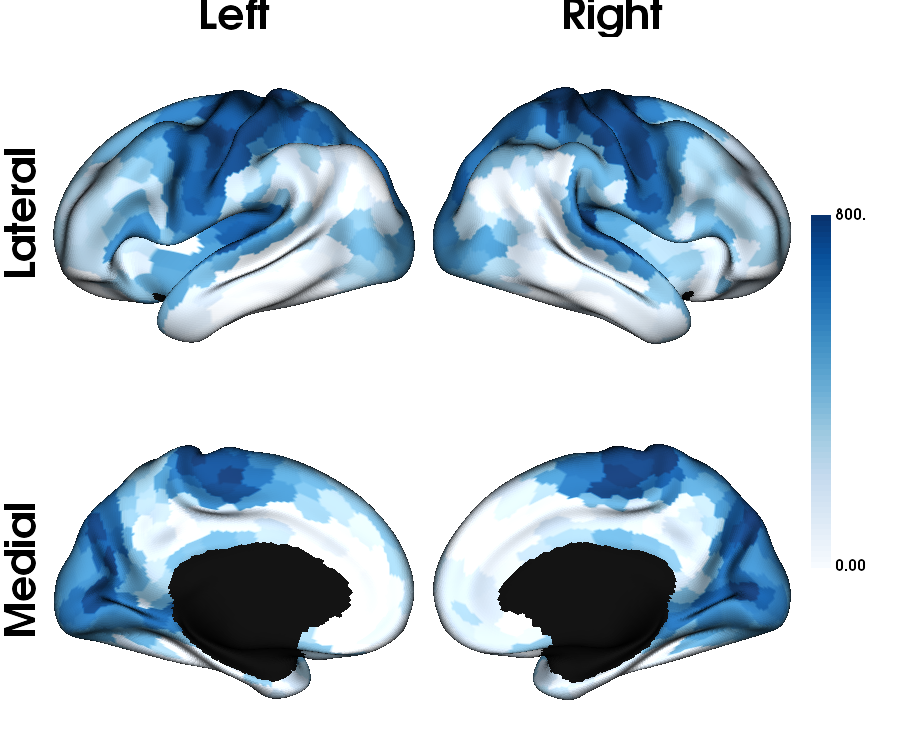

In [52]:
# Map the ROI to the surface vertices for plotting
g1_mri_vertex = map_to_labels(g1_mri, atlas, fill=np.nan, mask=mask != 0)

# Plot the vertex-wise mean intensity profile
plot_hemispheres(inf_left, inf_right, 
                 array_name=g1_mri_vertex, 
                 nan_color=(0, 0, 0, 1),
                 zoom=1.3, 
                 size=(900, 750), 
                 embed_nb=True,
                 color_bar='right',
                 layout_style='grid',
                 color_range=(0, Ndim),
                 cmap='Blues',
                 label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']}
                )

## Context decoding of MPC-MRI G1

In [54]:
from brainstat.context.meta_analysis import meta_analytic_decoder
from wordcloud import WordCloud

# Let's decode MPC-MRI G1 using terms provided in NeuroSynth
meta_analysis_G1 = meta_analytic_decoder("fslr32k", g1_mri_vertex, data_dir='./Neurosynth')

# Print terms with strongest positive and negative correlation with MPC-Hist G2
print(meta_analysis_G1)

# Generate a word cloud from the meta-analytic correlations - larger words mean stronger correlations
wc = WordCloud(background_color="white", random_state=0)
wc.generate_from_frequencies(frequencies=meta_analysis_G1.to_dict()["Pearson's r"])
plt.imshow(wc)
plt.axis("off")
plt.show()

2023-09-26 15:41:05,260 - brainstat - INFO - Fetching Neurosynth feature files. This may take several minutes if you haven't downloaded them yet.
2023-09-26 15:41:05,346 - brainstat - INFO - Running correlations with all Neurosynth features.
                      Pearson's r
sensorimotor cortex      0.523521
limb                     0.512741
cortex m1                0.496225
primary motor            0.495793
m1                       0.495277
...                           ...
orbitofrontal           -0.347059
medial orbitofrontal    -0.351528
cortex ofc              -0.372429
ofc                     -0.382965
dementia                -0.421253

[3228 rows x 1 columns]


AttributeError: 'ImageDraw' object has no attribute 'textbbox'